In [ ]:
#These imports don't all need to be here; these are based on the libraries we discussed in the proposal
import cv2
import scikit-image

## Lesson 6: Seeing the Moon
#### Learning Objectives:
After completing this lesson, users will be able to:
1. objective 1
2. objective 2
3. objective 3

_Python libraries introduced in this lesson:_ 

### Introduction

The Shinnecock are a federally recognized tribe based in eastern Long Island. Like many other tribes along the eastern seaboard, colonialism caused great hardship and loss for the Shinnecock. Land is put at the center of the colonialism discussion, but land is what the colonists gained; it is only the beginning of what indigenous tribes lost. Traditional language, ceremonies, and cultural practices were outlawed; children were taken away from their families; Shinnecock men were left to die on ships in storms while products were given preference to be taken ashore first. 

For several generations, the Shinnecock have been attempting to bring back lost cultural traditions, much of which has been done by travelling to other closely related communities and re-learning our ways. One of the recently revived traditions is the *Full Moon Ceremony* in which female members of the tribe honor _Nukimis Nanapashot_ (Grandmother Moon Spirit). The women of the tribe are tied to the water, the moon and its calendar. Each month, when the moon is full and its power strongest, this ceremony is held to allow the participants to cleanse themselves and their energy.

Today, in Western science, the moon is considered full on one particular date in the synodic month (New Moon to New Moon). However, this strict concept of fullness is not adhered to in the ceremonies. You may have noticed that moon "looks full" for a few days before and after the exact date of the full moon.

In this notebook, we will use computer vision to explore the fullness of the moon and compare this to the dates on which the ceremony is permitted to be held.

In [1]:
#TODO: Ceremonies can be held with three days on either side of the full moon.
#Circassian reference: https://thehamptons.com/indians/shipwreck/circassian.html

"How do current practitioners of Full Moon Ceremonies understand appropriate times for their performance? Can we usefully relate this to the visual appearance of the Moon during those times? What are the similarities and differences between this and strictly-defined percent illumination? Can we then apply our knowledge of these differences to back-compute possible ceremony dates using ephemeris information (because we don't have photos or records)?"

In [23]:
import netCDF4
import numpy as np

data=netCDF4.Dataset('OR_ABI-INST-CAL-LUN-M3C16_G16_s20170670622289_e20170670622289_c20170670622458.nc')

In [24]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    naming_authority: gov.nesdis.noaa
    institution: DOC/NOAA/NESDIS> U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services
    iso_series_metadata_id: fbd4e2a0-3749-11e3-aa6e-0800200c9a66
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    title: ABI Lunar Scan Calibrated Sample Data
    summary: ABI lunar scan calibrated sample data in a mode 3 timeline (epoch).
    keywords: SPECTRAL/ENGINEERING > VISIBLE WAVELENGTHS > SENSOR COUNTS, SPECTRAL/ENGINEERING > INFRARED WAVELENGTHS > SENSOR COUNTS
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Earth Science Keywords, Version 7.0.0.0.0
    instrument_type: GOES R Series Advanced Baseline Imager
    license: Unclassified data. Access is restricted to approved users only.
    production_site: WCDAS
    project: GOES
    dataset_name: ABI

In [25]:
for d in data.variables.keys():
    print(d)
    print(data.variables[d].dimensions)

t
('t',)
nominal_satellite_subpoint_lat
()
nominal_satellite_subpoint_lon
()
nominal_satellite_height
()
band_id
()
band_wavelength
()
center_y
()
center_x
()
radiance
('t', 'num_swaths', 'num_detectors', 'num_lunar_samples')
radiance_dqf
('t', 'num_swaths', 'num_detectors', 'num_lunar_samples')
data_file_version_container
()


In [26]:
l1a = data.variables['radiance']

In [27]:
l1a

<class 'netCDF4._netCDF4.Variable'>
float32 radiance(t, num_swaths, num_detectors, num_lunar_samples)
    _FillValue: -999.0
    long_name: lunar scan calibrated sample radiance values
    units: mW m-2 sr-1 (cm-1)-1
unlimited dimensions: t, num_lunar_samples
current shape = (1, 2, 412, 1408)
filling on

In [28]:
import matplotlib.pyplot as plt

In [29]:
%matplotlib inline

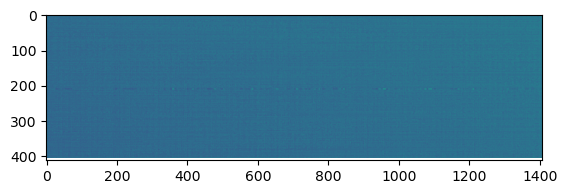

In [30]:
cs = plt.imshow(l1a[0,1,:,:])